# Animal classification AI
# Gradient Boosting

## TOC
- Student info
- Important note
- Important note
- Special credits
- Required imports and basic setup
- Step 1: Loading the data
   - 1.a: Saving the labels
   - 1.b: Saving dictionary of file paths
- Step 2: Data analysis
   - 2.a: showing some images
- Step 3: Choosing the descriptor
   - 3.a: Loading in the pickle data
   - 3.b: Encoding the images
   - 3.c: Validate loaded data
- Step 4: Making validation set(s) and test set(s)
- Step 5: Training the model
- Step 6: Generating CSV for submission
- Step 7: Automated optimization
   - Step 7.a: Finding optimal model
   - Step 7.b: Further fine-tuning optimal
   

## Student info
- **Name**: Bontinck Lennert
- **StudentID**: 568702
- **Affiliation**: VUB - Master Computer Science: AI

## Important note
In some codeblocks, the code might refer to variables from previous sections, in order to get accurate results code must be run top to bottom without skipping.

## Special credits
Some of the code used in this notebook is adopted or copied from the notebooks supplied in the Kaggle compition. A special thanks is given to Andries Rosseau for supplying us with this helpfull code.

## Required imports basic setup
All required imports for this file are taken care of once using the following code block. Installing the required libraries is discussed in the README of this GitHub repository. Some basic setup for the used libraries is also taken care of here

In [15]:
# set current optima
# manual logic
optima_test_fraction = 0.15
optima_test_fraction_balanced = True
optima_descriptor = "sift"
optima_clusters = 100

# model
optima_loss = 'deviance'
optima_learning_rate = 0.01
optima_n_estimators = 750 
optima_subsample = 0.75
optima_min_samples_split = 5 
optima_max_depth = 5

In [16]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# model
from sklearn.ensemble import GradientBoostingClassifier

# machine learning library
import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

# scoring
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy import stats as sstats

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions
import helpers

# specific helper functions for feature extraction
import features

# tell matplotlib that we plot in a notebook and make images high(er) resolution
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'svg'}

# used for counting files
import fnmatch

In [3]:
# datasets  location
dataset_path = '../images/'
# output location:
output_path = './'

In [4]:
# other path settings
dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

In [5]:
# load and save vars
def save_var_to_file(filename, var):
    with open('savefiles/' + filename +'.pkl','wb') as f:
        pickle.dump(var, f)

def get_var_from_file(filename):
    with open('savefiles/' + filename +'.pkl','rb') as f:
        return pickle.load(f)
    
    
#-------------------------

#save to file example
#save_var_to_file("folder/name", var_to_save)
    
#open from file example
#get_var_from_file = get_var_from_file("folder/name")

## Step 1: Loading the data
Before we can start exploring our data and making models we have to setup everything that is needed to access the data.

The data is provided in the Kaggle compition and saved under a folder "test" and "train" inside the folder "images" which is saved in this files parent directory as set up in the previous basic setup step.

### 1.a: Saving the labels
The training data provided is saved inside a folder which name corresponds to the label of the data inside that folder. Thus getting the labels of the data is nothing more then getting all folder names inside the "train" folder.

In [6]:
train_images_folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in train_images_folder_paths]))
amount_of_labels = label_strings.shape[0]

print("Amount of classes (labels): ", amount_of_labels)
print("\nLabels: ", label_strings)

Amount of classes (labels):  12

Labels:  ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


### 1.b: Saving dictionary of file paths
Since loading all images of the train set into memory at once is hardly feasible, we simply collect all their filepaths and load them on demand. Therefore, we build a dictionary of the filepaths to all our train images, sorted by label. We do the same for our test images.

In [7]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

## Step 2: Data analysis
Before rigorously testing different models available it's important to take a look at the data that's supplied to us. This will not only validate the data is correctly loaded in the previous step but will also give us some hint as to what our data looks like, what it's distribution is...

This step can be done in a separate Jupyter Notebook "data_analysis" and thus the code is not repeated here, we do however print some of the images here to be sure the setup in the previous step succeeded

### 2.a: showing some images
In this step we'll display the first five images in the train set provided for the Kaggle compitition.

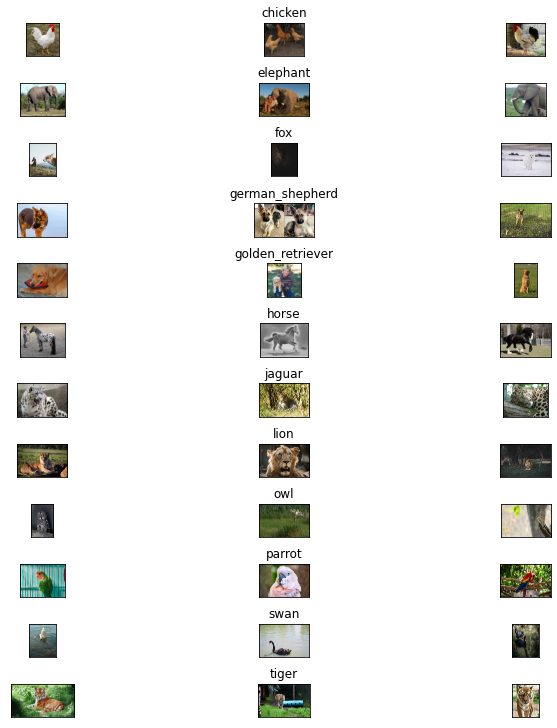

In [8]:
fig, axes = plt.subplots(nrows=amount_of_labels, ncols=3, constrained_layout=True, figsize=(10, 10))

[ax.get_xaxis().set_visible(False) for ax_row in axes for ax in ax_row]
[ax.get_yaxis().set_visible(False) for ax_row in axes for ax in ax_row]

for idx, label_string in enumerate(label_strings):
    images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in train_paths[label_string][:5]]

    for colidx in range(3):
        axes[idx, colidx].imshow(images[colidx])
        if colidx == 1: # if this is the center column
            axes[idx, colidx].set_title(label_string)

plt.show()    

## Step 3: Choosing the descriptor
From the information gathered in step 2, a preffered descriptor and proposed amount of clusters is loaded.

### 3.a: Loading in the pickle data
The "descriptor_desired" and "amount_of_clusters" parameters could benefit from fine-tuning. See inline comment to check wether or not they have been fine-tuned. More details in section: Fine-tuning the input.

The default "createCodebook" helper function is used to cluster the data. This can be optimised later.

In [9]:
# fine-tuning of these parameters has been done!
descriptor_desired = optima_descriptor
amount_of_clusters = optima_clusters

# ----------------- open pickle files ----------------- 
with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)
    
print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))

with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)
        
print('Number of encoded test images: {}'.format(len(test_features_from_pkl)))

# ----------------- get the wanted features ----------------- 
# Can be optimised later on!
clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=amount_of_clusters)

Number of encoded train images: 4042
Number of encoded test images: 4035
training took 23.59661626815796 seconds


### 3.b: Encoding the images
It's important to note that the test data has to be encoded using the same logic as well!

In [10]:
# ----------------- encode all train images ----------------- 
train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)
    
# ----------------- make labels numerical ----------------- 
train_labels_text = train_labels[:]

label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)

print(train_labels_text[:10])
print(train_labels[:10])
    
# ----------------- encode all test images ----------------- 
test_data_by_kaggle = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data_by_kaggle.append(bow_feature_vector)

['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]


### 3.c: Validate loaded data
This step prints some output to check wether or not the previous step succeeded.

In [11]:
# ----------------- print some info ----------------- 
print("Amoount of interesting points available: ", len(train_features_from_pkl[0][2]))
print("Amoount of clusters requested: ", len(train_data[0]))

print("\nTrain labels: ", train_labels[:1])
print("Train data: \n", train_data[:1])

print("\nTest data by Kaggle: \n", test_data_by_kaggle[:1])

Amoount of interesting points available:  500
Amoount of clusters requested:  100

Train labels:  [0]
Train data: 
 [array([0.03325951, 0.09977852, 0.13303802, 0.09977852, 0.09977852,
       0.09977852, 0.09977852, 0.06651901, 0.14966777, 0.09977852,
       0.14966777, 0.06651901, 0.13303802, 0.08314876, 0.13303802,
       0.06651901, 0.08314876, 0.19955703, 0.01662975, 0.09977852,
       0.16629753, 0.04988926, 0.08314876, 0.06651901, 0.13303802,
       0.03325951, 0.04988926, 0.09977852, 0.04988926, 0.24944629,
       0.08314876, 0.03325951, 0.06651901, 0.23281654, 0.03325951,
       0.06651901, 0.03325951, 0.        , 0.09977852, 0.09977852,
       0.03325951, 0.09977852, 0.14966777, 0.        , 0.04988926,
       0.19955703, 0.03325951, 0.14966777, 0.04988926, 0.01662975,
       0.09977852, 0.14966777, 0.06651901, 0.04988926, 0.03325951,
       0.14966777, 0.16629753, 0.01662975, 0.14966777, 0.18292728,
       0.09977852, 0.13303802, 0.04988926, 0.04988926, 0.01662975,
       0.033

## Step 4: Making validation set(s) and test set(s)
As per requirement of the Kaggle compitition, the score on the test data can not be used for optimilisation.
This is logical since the score would then not represent a score on completely unseen data anymore.
This is why we need to split the training data a second time into a training set and a validation set.

This splitting could benefit from fine-tuning.
See inline comment to check wether or not it has been fine-tuned.
It is chosen to take into account the unbalance of the dataset given.
More information in section: Fine-tuning the validation set

In [17]:
# fine-tuning of these parameters has been done!
test_fraction = optima_test_fraction
balanced = optima_test_fraction_balanced

if balanced:
    train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, stratify=train_labels)
else:
    train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, random_state=0)


#validating the split
print("Train labels: ", train_labels_split[:2])
print("\nTrain data: \n", train_data_split[:2])

Train labels:  [10  7]

Train data: 
 [array([0.73821536, 0.        , 0.01210189, 0.02420378, 0.01210189,
       0.        , 0.02420378, 0.        , 0.19363026, 0.01210189,
       0.        , 0.        , 0.        , 0.01210189, 0.        ,
       0.01210189, 0.18152837, 0.01210189, 0.        , 0.01210189,
       0.        , 0.        , 0.        , 0.01210189, 0.        ,
       0.01210189, 0.06050946, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01210189,
       0.56878889, 0.08471324, 0.        , 0.        , 0.        ,
       0.03630567, 0.        , 0.01210189, 0.02420378, 0.02420378,
       0.01210189, 0.        , 0.        , 0.        , 0.04840756,
       0.        , 0.        , 0.01210189, 0.01210189, 0.        ,
       0.        , 0.02420378, 0.        , 0.        , 0.18152837,
       0.02420378, 0.        , 0.01210189, 0.06050946, 0.        ,
       0.01210189, 0.        , 0.01210189, 0.        , 0.01210189,
       0.02420378, 0.01

## Step 5: Training the model
After all of this work we can finally start with training our model.

In [18]:
# step 1: import the model
from sklearn.ensemble import GradientBoostingClassifier

# step 2: create a model instance 
# (this is a model object that can be trained, tuned and used)

model = GradientBoostingClassifier(loss = optima_loss,
                                    learning_rate = optima_learning_rate,
                                    n_estimators = optima_n_estimators,
                                    subsample = optima_subsample,
                                    min_samples_split = optima_min_samples_split,
                                    max_depth = optima_max_depth)

# step 3: train the model on the training data

model.fit(train_data_split, train_labels_split)

# step 4: predict labels for test data 

predictions_train = model.predict(train_data_split)
predictions_probability_train = model.predict_proba(train_data_split)

predictions_test = model.predict(test_data_split)
predictions_probability_test = model.predict_proba(test_data_split)

# step 4: calculate the accuracy of the model on the train set and on the test set
# We try to use log_loss where possible which corresponds to the scoring used on the Kaggle compitition

train_score = log_loss(train_labels_split, predictions_probability_train)
test_score = log_loss(test_labels_split, predictions_probability_test)

folds = StratifiedKFold(n_splits=5, shuffle=True)
scores_cross = - cross_val_score(model, train_data, train_labels, cv=folds, scoring='neg_log_loss', n_jobs=-1)
score_cross = scores_cross.mean()

print("Accuracy of model (single log_loss): ",train_score," (train), ",test_score," (test)")
print("Accuracy of model (cross-fold log_loss): ",score_cross)

Accuracy of model (single log_loss):  0.21633837027770256  (train),  1.635826651115044  (test)
Accuracy of model (cross-fold log_loss):  1.622464388152236


## Step 6: Generating CSV for submission

In [19]:
# Do predictions on the actual test data
predictions_probability_test_data_by_kaggle = model.predict_proba(test_data_by_kaggle)

# Build a submission
pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename('5/gradient_boosting', 'csv'))
helpers.writePredictionsToCsv(predictions_probability_test_data_by_kaggle, pred_file_path, label_strings)

---

---

## Step 7: Automated optimization

Further discussed in section: Scoring and methodology for fine-tuning

### Step 7.a: Finding optimal model

results experiment 1 (top 10):
```
-1.689 (+/-0.035) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__loss': 'deviance', 'ensemblemodel__n_estimators': 500}
-1.707 (+/-0.056) for {'ensemblemodel__learning_rate': 0.1, 'ensemblemodel__loss': 'deviance', 'ensemblemodel__n_estimators': 100}
-1.730 (+/-0.047) for {'ensemblemodel__learning_rate': 0.1, 'ensemblemodel__loss': 'deviance', 'ensemblemodel__n_estimators': 50}
-1.755 (+/-0.033) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__loss': 'deviance', 'ensemblemodel__n_estimators': 250}
-1.766 (+/-0.058) for {'ensemblemodel__learning_rate': 0.1, 'ensemblemodel__loss': 'deviance', 'ensemblemodel__n_estimators': 250}
-1.914 (+/-0.021) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__loss': 'deviance', 'ensemblemodel__n_estimators': 100}
-1.923 (+/-0.089) for {'ensemblemodel__learning_rate': 0.1, 'ensemblemodel__loss': 'deviance', 'ensemblemodel__n_estimators': 500}
-2.049 (+/-0.015) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__loss': 'deviance', 'ensemblemodel__n_estimators': 50}
-2.051 (+/-0.015) for {'ensemblemodel__learning_rate': 0.001, 'ensemblemodel__loss': 'deviance', 'ensemblemodel__n_estimators': 500}
-2.165 (+/-0.012) for {'ensemblemodel__learning_rate': 0.001, 'ensemblemodel__loss': 'deviance', 'ensemblemodel__n_estimators': 250}
...
```


results experiment 2 (top 10):
```
-1.634 (+/-0.062) for {'ensemblemodel__max_depth': 5, 'ensemblemodel__min_samples_split': 5, 'ensemblemodel__subsample': 0.75}
-1.636 (+/-0.063) for {'ensemblemodel__max_depth': 5, 'ensemblemodel__min_samples_split': 3, 'ensemblemodel__subsample': 0.75}
-1.636 (+/-0.068) for {'ensemblemodel__max_depth': 5, 'ensemblemodel__min_samples_split': 5, 'ensemblemodel__subsample': 0.5}
-1.637 (+/-0.063) for {'ensemblemodel__max_depth': 5, 'ensemblemodel__min_samples_split': 2, 'ensemblemodel__subsample': 0.75}
-1.638 (+/-0.071) for {'ensemblemodel__max_depth': 5, 'ensemblemodel__min_samples_split': 3, 'ensemblemodel__subsample': 0.5}
-1.640 (+/-0.073) for {'ensemblemodel__max_depth': 5, 'ensemblemodel__min_samples_split': 2, 'ensemblemodel__subsample': 0.5}
-1.641 (+/-0.084) for {'ensemblemodel__max_depth': 7, 'ensemblemodel__min_samples_split': 2, 'ensemblemodel__subsample': 0.5}
-1.642 (+/-0.078) for {'ensemblemodel__max_depth': 7, 'ensemblemodel__min_samples_split': 3, 'ensemblemodel__subsample': 0.5}
-1.643 (+/-0.070) for {'ensemblemodel__max_depth': 7, 'ensemblemodel__min_samples_split': 5, 'ensemblemodel__subsample': 0.5}
-1.648 (+/-0.072) for {'ensemblemodel__max_depth': 7, 'ensemblemodel__min_samples_split': 5, 'ensemblemodel__subsample': 0.75}
...
```



In [ ]:
model_pipeline = Pipeline([
    ('ensemblemodel', GradientBoostingClassifier(loss = optima_loss,
                                                 learning_rate = optima_learning_rate,
                                                 n_estimators = optima_n_estimators,
                                                 subsample = optima_subsample,
                                                 min_samples_split = optima_min_samples_split,
                                                 max_depth = optima_max_depth))
])

# ----------------- open pickle files ----------------- 
with open(filepattern_descriptor_train.format(optima_descriptor), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)

with open(filepattern_descriptor_test.format(optima_descriptor), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)

# ----------------- get the wanted features ----------------- 
clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=optima_clusters)

# ----------------- encode all train images ----------------- 
train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)

# ----------------- make labels numerical ----------------- 
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)

# ----------------- encode all test images ----------------- 
test_data_by_kaggle = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data_by_kaggle.append(bow_feature_vector)


# Set the parameters by cross-validation
tuned_parameters = [{'ensemblemodel__loss': ['deviance', 'exponential'],
                     'ensemblemodel__learning_rate': [0.001, 0.01 , 0.1, 0.5],
                     'ensemblemodel__n_estimators' : [50, 100, 250, 500]
                    }]

# Use gridsearch taking into account unbalance with folds and using log loss
folds = StratifiedKFold(n_splits=5, shuffle=True)
CV = GridSearchCV(model_pipeline, tuned_parameters, cv=folds, scoring='neg_log_loss', n_jobs=-1, verbose=3)
CV.fit(train_data, train_labels)

print("Best parameter set found on development set: ", CV.best_params_)

print("Grid scores on training data set:\n")
cv_means = CV.cv_results_['mean_test_score']
cv_stds = CV.cv_results_['std_test_score']
for mean, std, params in zip(cv_means, cv_stds, CV.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

save_var_to_file("gb_grid1", CV)    

#### let's look at the other parameters seperately now

In [16]:
model_pipeline = Pipeline([
    ('ensemblemodel', GradientBoostingClassifier(loss = optima_loss,
                                                 learning_rate = optima_learning_rate,
                                                 n_estimators = optima_n_estimators,
                                                 subsample = optima_subsample,
                                                 min_samples_split = optima_min_samples_split,
                                                 max_depth = optima_max_depth))
])

# ----------------- open pickle files ----------------- 
with open(filepattern_descriptor_train.format(optima_descriptor), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)

with open(filepattern_descriptor_test.format(optima_descriptor), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)

# ----------------- get the wanted features ----------------- 
clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=optima_clusters)

# ----------------- encode all train images ----------------- 
train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)

# ----------------- make labels numerical ----------------- 
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)

# ----------------- encode all test images ----------------- 
test_data_by_kaggle = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data_by_kaggle.append(bow_feature_vector)


# Set the parameters by cross-validation
tuned_parameters = [{'ensemblemodel__subsample' : [0.5, 0.75, 1.0, 1.5],
                     'ensemblemodel__min_samples_split' : [2, 3, 5],
                     'ensemblemodel__max_depth' : [3, 5, 7, 10]
                    }]

# Use gridsearch taking into account unbalance with folds and using log loss
folds = StratifiedKFold(n_splits=5, shuffle=True)
CV = GridSearchCV(model_pipeline, tuned_parameters, cv=folds, scoring='neg_log_loss', n_jobs=-1, verbose=3)
CV.fit(train_data, train_labels)

print("Best parameter set found on development set: ", CV.best_params_)

print("Grid scores on training data set:\n")
cv_means = CV.cv_results_['mean_test_score']
cv_stds = CV.cv_results_['std_test_score']
for mean, std, params in zip(cv_means, cv_stds, CV.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

save_var_to_file("gb_grid2", CV)

training took 23.095969676971436 seconds
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 135.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 1116.0min finished


Best parameter set found on development set:  {'ensemblemodel__max_depth': 5, 'ensemblemodel__min_samples_split': 5, 'ensemblemodel__subsample': 0.75}
Grid scores on training data set:

-1.665 (+/-0.067) for {'ensemblemodel__max_depth': 3, 'ensemblemodel__min_samples_split': 2, 'ensemblemodel__subsample': 0.5}
-1.663 (+/-0.061) for {'ensemblemodel__max_depth': 3, 'ensemblemodel__min_samples_split': 2, 'ensemblemodel__subsample': 0.75}
-1.690 (+/-0.053) for {'ensemblemodel__max_depth': 3, 'ensemblemodel__min_samples_split': 2, 'ensemblemodel__subsample': 1.0}
nan (+/-nan) for {'ensemblemodel__max_depth': 3, 'ensemblemodel__min_samples_split': 2, 'ensemblemodel__subsample': 1.5}
-1.665 (+/-0.055) for {'ensemblemodel__max_depth': 3, 'ensemblemodel__min_samples_split': 3, 'ensemblemodel__subsample': 0.5}
-1.663 (+/-0.059) for {'ensemblemodel__max_depth': 3, 'ensemblemodel__min_samples_split': 3, 'ensemblemodel__subsample': 0.75}
-1.691 (+/-0.055) for {'ensemblemodel__max_depth': 3, 'ensemb

### Step 7.b: Further fine-tuning optimal
Once an optimal is found further-finetune it and do some human reasoning

results experiment 1 (top 10) - optima remained equal thus no further experiment is needed:
```
-1.651 (+/-0.063) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 500}
-1.702 (+/-0.050) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 250}
-1.747 (+/-0.079) for {'ensemblemodel__learning_rate': 0.1, 'ensemblemodel__n_estimators': 50}
-1.772 (+/-0.103) for {'ensemblemodel__learning_rate': 0.1, 'ensemblemodel__n_estimators': 100}
-1.855 (+/-0.041) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 100}
-1.987 (+/-0.138) for {'ensemblemodel__learning_rate': 0.1, 'ensemblemodel__n_estimators': 250}
-1.997 (+/-0.027) for {'ensemblemodel__learning_rate': 0.001, 'ensemblemodel__n_estimators': 500}
-2.001 (+/-0.034) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 50}
-2.124 (+/-0.021) for {'ensemblemodel__learning_rate': 0.001, 'ensemblemodel__n_estimators': 250}
-2.245 (+/-0.010) for {'ensemblemodel__learning_rate': 0.001, 'ensemblemodel__n_estimators': 100}
...
```

results experiment 2 (top 10) - trying more estimators
```
-1.613 (+/-0.091) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 750}
-1.617 (+/-0.085) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 600}
-1.620 (+/-0.107) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 1000}
-1.625 (+/-0.081) for {'ensemblemodel__learning_rate': 0.005, 'ensemblemodel__n_estimators': 1000}
-1.627 (+/-0.076) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 500}
-1.643 (+/-0.079) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 400}
-1.645 (+/-0.070) for {'ensemblemodel__learning_rate': 0.005, 'ensemblemodel__n_estimators': 750}
-1.669 (+/-0.066) for {'ensemblemodel__learning_rate': 0.005, 'ensemblemodel__n_estimators': 600}
-1.690 (+/-0.062) for {'ensemblemodel__learning_rate': 0.005, 'ensemblemodel__n_estimators': 500}
-1.723 (+/-0.059) for {'ensemblemodel__learning_rate': 0.005, 'ensemblemodel__n_estimators': 400}
...
```


In [12]:
model_pipeline = Pipeline([
    ('ensemblemodel', GradientBoostingClassifier(loss = optima_loss,
                                                 learning_rate = optima_learning_rate,
                                                 n_estimators = optima_n_estimators,
                                                 subsample = optima_subsample,
                                                 min_samples_split = optima_min_samples_split,
                                                 max_depth = optima_max_depth))
])

# ----------------- open pickle files ----------------- 
with open(filepattern_descriptor_train.format(optima_descriptor), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)

with open(filepattern_descriptor_test.format(optima_descriptor), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)

# ----------------- get the wanted features ----------------- 
clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=optima_clusters)

# ----------------- encode all train images ----------------- 
train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)

# ----------------- make labels numerical ----------------- 
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)

# ----------------- encode all test images ----------------- 
test_data_by_kaggle = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data_by_kaggle.append(bow_feature_vector)


# Set the parameters by cross-validation
tuned_parameters = [{'ensemblemodel__learning_rate': [0.001, 0.01 , 0.1, 0.5],
                     'ensemblemodel__n_estimators' : [50, 100, 250, 500]
                    }]

# Use gridsearch taking into account unbalance with folds and using log loss
folds = StratifiedKFold(n_splits=3, shuffle=True)
CV = GridSearchCV(model_pipeline, tuned_parameters, cv=folds, scoring='neg_log_loss', n_jobs=-1, verbose=3)
CV.fit(train_data, train_labels)

print("Best parameter set found on development set: ", CV.best_params_)

print("Grid scores on training data set:\n")
cv_means = CV.cv_results_['mean_test_score']
cv_stds = CV.cv_results_['std_test_score']
for mean, std, params in zip(cv_means, cv_stds, CV.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

save_var_to_file("gb_grid1_further", CV)    

training took 24.26115894317627 seconds
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 40.0min finished


Best parameter set found on development set:  {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 500}
Grid scores on training data set:

-2.301 (+/-0.007) for {'ensemblemodel__learning_rate': 0.001, 'ensemblemodel__n_estimators': 50}
-2.245 (+/-0.010) for {'ensemblemodel__learning_rate': 0.001, 'ensemblemodel__n_estimators': 100}
-2.124 (+/-0.021) for {'ensemblemodel__learning_rate': 0.001, 'ensemblemodel__n_estimators': 250}
-1.997 (+/-0.027) for {'ensemblemodel__learning_rate': 0.001, 'ensemblemodel__n_estimators': 500}
-2.001 (+/-0.034) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 50}
-1.855 (+/-0.041) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 100}
-1.702 (+/-0.050) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 250}
-1.651 (+/-0.063) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 500}
-1.747 (+/-0.079) for {'ensemblemodel__learning_rate': 0.1, 'ensem

In [14]:
model_pipeline = Pipeline([
    ('ensemblemodel', GradientBoostingClassifier(loss = optima_loss,
                                                 learning_rate = optima_learning_rate,
                                                 n_estimators = optima_n_estimators,
                                                 subsample = optima_subsample,
                                                 min_samples_split = optima_min_samples_split,
                                                 max_depth = optima_max_depth))
])

# ----------------- open pickle files ----------------- 
with open(filepattern_descriptor_train.format(optima_descriptor), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)

with open(filepattern_descriptor_test.format(optima_descriptor), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)

# ----------------- get the wanted features ----------------- 
clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=optima_clusters)

# ----------------- encode all train images ----------------- 
train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)

# ----------------- make labels numerical ----------------- 
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)

# ----------------- encode all test images ----------------- 
test_data_by_kaggle = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data_by_kaggle.append(bow_feature_vector)


# Set the parameters by cross-validation
tuned_parameters = [{'ensemblemodel__learning_rate': [0.005, 0.01 , 0.05, 0.1],
                     'ensemblemodel__n_estimators' : [400, 500, 600, 750, 1000]
                    }]

# Use gridsearch taking into account unbalance with folds and using log loss
folds = StratifiedKFold(n_splits=5, shuffle=True)
CV = GridSearchCV(model_pipeline, tuned_parameters, cv=folds, scoring='neg_log_loss', n_jobs=-1, verbose=3)
CV.fit(train_data, train_labels)

print("Best parameter set found on development set: ", CV.best_params_)

print("Grid scores on training data set:\n")
cv_means = CV.cv_results_['mean_test_score']
cv_stds = CV.cv_results_['std_test_score']
for mean, std, params in zip(cv_means, cv_stds, CV.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

save_var_to_file("gb_grid_more_estimators", CV)

training took 23.977579832077026 seconds
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 270.0min finished


Best parameter set found on development set:  {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 750}
Grid scores on training data set:

-1.723 (+/-0.059) for {'ensemblemodel__learning_rate': 0.005, 'ensemblemodel__n_estimators': 400}
-1.690 (+/-0.062) for {'ensemblemodel__learning_rate': 0.005, 'ensemblemodel__n_estimators': 500}
-1.669 (+/-0.066) for {'ensemblemodel__learning_rate': 0.005, 'ensemblemodel__n_estimators': 600}
-1.645 (+/-0.070) for {'ensemblemodel__learning_rate': 0.005, 'ensemblemodel__n_estimators': 750}
-1.625 (+/-0.081) for {'ensemblemodel__learning_rate': 0.005, 'ensemblemodel__n_estimators': 1000}
-1.643 (+/-0.079) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 400}
-1.627 (+/-0.076) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 500}
-1.617 (+/-0.085) for {'ensemblemodel__learning_rate': 0.01, 'ensemblemodel__n_estimators': 600}
-1.613 (+/-0.091) for {'ensemblemodel__learning_rate': 0.01, '